<a href="https://colab.research.google.com/github/gaurav-kr92/agent_based_modeling_01/blob/main/mesa_AGM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies


In [1]:
!pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import mesa
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 

# Helper function

In [3]:
def get_distance(pos1, pos2):
  '''
  calculate the ecludian distance between two points
  used in trade.move()
  '''

  x1, y1 = pos1
  x2, y2 = pos2
  
  return math.sqrt((x1-x2)**2 + (y1-y2)**2)

def flatten(list_of_list):
  '''
  helper function for model datacollector for trade price;
  collapse agent price list into one list 
  '''

  return [item for sublist in list_of_list for item in sublist]

def geometric_mean(list):
  '''
  find the geometric mean of list of prices 
  '''
  return np.exp(np.log(list).mean())

def get_trade(agent):
  '''
  '''
  if type(agent)== Trader:
    return agent.trade_partners
  else:
    return None  

# Resource Classes

In [4]:
class Sugar(mesa.Agent):
  ''' 
  Sugar: contains amount of sugar
         grows one amount of sugar at each turn 

  '''
  def __init__(self,unique_id,model, pos ,max_sugar):
    super().__init__(unique_id, model)
    self.pos = pos
    self.amount = max_sugar
    self.max_sugar = max_sugar
    
  def step(self):
    '''
    sugar growth function , adds one unit sugar each step untill max sugar 
    '''
    self.amount = min([self.amount+1, self.max_sugar])  


In [5]:
class Spice(mesa.Agent):
  '''
  spice: contain amount of spices
         grows one amount of spices at each turn 

  '''
  def __init__(self,unique_id,model,pos, max_spice):
    super().__init__(unique_id, model)
    self.pos = pos
    self.amount = max_spice # this tell how much spice at a time; 
    self.max_spice = max_spice # tell how much maximum spice were present at that location

  def step(self):
    '''
    spice growth function , adds one unit sugar each step untill max sugar 
    '''
    self.amount = min([self.amount+1, self.max_spice])  
   # print(self.unique_id, self.amount, self.max_spice)
  


# trader class

In [6]:
class Trader(mesa.Agent):
  
  def __init__(self,unique_id, model, pos,moore = False, sugar=0,spice=0,
               sugar_metabolism=0, spice_metabolism=0, vision=0):
    super().__init__(unique_id,model)
    self.pos = pos
    self.moore = moore
    self.sugar = sugar
    self.spice = spice
    self.sugar_metabolism = sugar_metabolism
    self.spice_metabolism = spice_metabolism
    self.vision = vision
    self.prices = []
    self.trade_partners = []

  def get_sugar(self, pos):
    '''
    used in get_sugar_amount()
    used in eat fxn
    '''
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if type(agent) is Sugar:
        return agent
    return None

  def get_spice(self,pos):
    '''
    used in get_spice_amount
    used in eat fxn
    '''
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:    
      if type(agent) is Spice:   
        return agent
    return None    

  def get_sugar_amount(self,pos): 

    '''
    used in slf.move() as a part of self.calulate_welfare()
    '''
    sugar_patch = self.get_sugar(pos)
    if sugar_patch:
      return sugar_patch.amount
    return 0     

  def get_spice_amount(self,pos):
    '''
    used in self.move() as a part of self.calculate_welfare()
    '''
    spice_patch = self.get_spice(pos)
    if spice_patch:
      return spice_patch.amount
    return 0  

  def get_trader(self,pos): 
    '''
    helper function of self.trade_with_neighbors fxn;
    '''
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if isinstance(agent,Trader):
        return agent
  

  def is_occupied_by_other(self,pos):
    # helper function of part move function; 
    if pos == self.pos:
      return False
    # get content of each cell in neighborhood
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for a in this_cell:
      # see if occupied by other trader agent; 
      if isinstance(a,Trader):
        return True
    return False

  def calculate_welfare(self,sugar,spice):
    '''
    helper function to calculate part 2 of self.move()  
    and also in self.trade fxn;
    '''
    # calcualte total resources 
    m_total = self.sugar_metabolism + self.spice_metabolism
    #Cobb-Douglus functional form 
    return sugar**(self.sugar_metabolism/m_total) * spice**(self.spice_metabolism/m_total)

  def is_starved(self):
    '''
    helper function for self.maybe_die()
    '''

    return (self.sugar <=0) or(self.spice <=0)

  def calculate_MRS(self,sugar,spice):  
    '''
    helper function in self.trade; 
    Detrmine what trader agent need and what he can give up
    '''
    return (spice/self.spice_metabolism)/(sugar/self.sugar_metabolism)

  def calculate_sell_spice_amount(self, price):
    '''
    helper function for maybe_sell_price; 
    '''
    if price >=1:
      spice =int(price)
      sugar = 1
    else:
      sugar = int(1/price)
      spice = 1
    return sugar, spice

  def sell_spice(self,other,sugar, spice):
    '''
    used in self.maybe_sell_spice()
    exchange sugar and spice between traders; 

    '''

    self.sugar += sugar
    self.spice -= spice
    other.sugar -= sugar
    other.spice += spice 


  def maybe_sell_price(self,other,price, self_welfare, other_welfare):
    '''
    helper function for self.trade
    '''
    sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)
 
    # Assess new sugar and spice amooount  - what the changes did occur; 
    self_sugar = self.sugar + sugar_exchanged
    self_spice = self.spice - spice_exchanged
    other_sugar = other.sugar - sugar_exchanged
    other_spice = other.spice + spice_exchanged

    # Double check to ensure agent have resources; 

    if((self_sugar <= 0)or
       (self_spice <= 0)or
       (other_sugar<= 0)or
       (other_spice <=0)):
       return False

   # trade criteria #1 - are both agents better off;
    both_agents_better_off = (
      (self_welfare < self.calculate_welfare(self_sugar,self_spice)) and
      (other_welfare < other.calculate_welfare(other_sugar,other_spice)))   
      
    #trade criteria #2- is their mrs crossing 
    mrs_not_crossing = self.calculate_MRS(self_sugar,self_spice) > other.calculate_MRS(other_sugar,other_spice)

    if not(both_agents_better_off and mrs_not_crossing):
      return False
    # Creteria match , execute trade; 
    self.sell_spice(other,sugar_exchanged,spice_exchanged)

    return True
   
  def trade(self,other):
    '''
    helper function for trade_with_neighbor;
    other is trader agent object;
    '''

    # sanity check to verify code is working as expected; 
    assert self.sugar >0 
    assert self.spice >0
    assert other.sugar >0
    assert other.spice >0

    # Calculate marginal rate of substitution a/c to (growing artificial socities p.no = 101)
    mrs_self = self.calculate_MRS(self.sugar, self.spice)   
    mrs_other = other.calculate_MRS(other.sugar,other.spice)

    # Calculate each agent welfare; 
    self_welfare = self.calculate_welfare(self.sugar,self.spice)
    other_welfare = other.calculate_welfare(other.sugar, other.spice)

    if math.isclose(mrs_self,mrs_other):
      return

    # calculate price as geometric mean of mrs_self and mrs_other
    price = math.sqrt(mrs_self*mrs_other)

    if mrs_self > mrs_other:
      # self is buyer of sugar, spice seller
      sold = self.maybe_sell_price(other,price,self_welfare,other_welfare)
      # if no trade- criteria not met; 
      if not sold:
        return 
    else:
      # self is a spice buyer and sugar seller
      sold = other.maybe_sell_price(self,price,other_welfare,self_welfare)
      # if no trade- criteria met
      if not sold:
        return 

    # capture the data;
    self.prices.append(price)
    self.trade_partners.append(other.unique_id)  

    # continue trading 
    self.trade(other)  


       #.                       MAIN TRADER FUNCTION                                .#

  def move(self):
    '''
    Function for trader agent to identify optimal move for each step in 4 parts 
    1- identify all possible move; 
    2- determine which move maximize welfare; 
    3- find closest best option;
    4- move
    '''
    # 1- all possible move;
    
    neighbors = [i 
                 for i in self.model.grid.get_neighborhood(
                    self.pos,self.moore,True,self.vision
                 ) if not self.is_occupied_by_other(i)]    
   
    # 2 determine which maximise the welfare ; 
    welfares = [
      self.calculate_welfare(self.sugar + self.get_sugar_amount(pos),
                            self.spice + self.get_spice_amount(pos)) for pos in neighbors
    ]   
    
    # 3. Find the closest best option; 
    # find the highest welfare in welfares 

    max_welfare = max(welfares)
    # get the indices of max welfare; 
    candidate_indics = [i for i in range(len(welfares))
                        if math.isclose(welfares[i],max_welfare)]
    # convert this indicds to pos
    candidates = [neighbors[i] for i in candidate_indics]
    
    #print(neighbors, candidate_indics, candidates)

    min_dist = min(get_distance(self.pos,pos) for pos in candidates)

    final_candidates = [pos for pos in candidates
                   if math.isclose(min_dist,get_distance(self.pos,pos),rel_tol = 1e-02)]
    self.random.shuffle(final_candidates)

    # 4. move agent; 
    self.model.grid.move_agent(self, final_candidates[0])
    

  def eat(self):
    '''
    function for agent to get local resources and consume sugar and spices
    '''

    #get sugar
    sugar_patch = self.get_sugar(self.pos)
    if sugar_patch:
      self.sugar += sugar_patch.amount
      sugar_patch.amount = 0
    self.sugar -= self.sugar_metabolism

    # get spice
    spice_patch = self.get_spice(self.pos)
    if spice_patch:  
      self.spice += spice_patch.amount
      spice_patch.amount = 0
    self.spice -= self.spice_metabolism 

  def maybe_die(self):
    '''
    function to remove traders who has consume all its sugar and spice
    '''
    if self.is_starved():
      #print(self.unique_id, self.model.schedule.get_type_count(Trader))
      self.model.grid.remove_agent(self)
      self.model.schedule.remove(self)
      #print(self.unique_id, self.model.schedule.get_type_count(Trader))

  def trade_with_neighbors(self):
    '''
    function for trader agent to decide who to trade with in three parts

    1 - Identify the neighbors who can trade;
    2 - trade(2 sessions)
    3 - collect the data
    '''

    neighbor_agent = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
                      self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)
    ]
    
    # trader return price and trade network (who agent traded with;)
    if len(neighbor_agent)==0:
      return 

    # else iterate through the neighborinf cell and trade; 
    for a in neighbor_agent:
      if a:
        self.trade(a)  

    return 


# Model class

In [27]:
class SugarscapeG1mt(mesa.Model):
  '''
  A modal class to manage Sugarscape with trader(G1mt)
  from growing artifical socities by axtell epstein
  '''

  def __init__(self, width=50, height=50, intial_population = 250
               ,endowent_min = 25, endowent_max = 50, metabolism_min =1,
               metabolism_max = 5, vision_min = 1, vision_max = 5):

    #Intiate width and height of sugarscape; 
    self.width = width
    self.height = height

    #Intiate population attributes 
    self.intial_population = intial_population 
    self.endowent_min = endowent_min
    self.endowent_max = endowent_max
    self.metabolism_min = metabolism_min
    self.metabolism_max = metabolism_max
    self.vision_min = vision_min
    self.vision_max = vision_max
    self.running = True

    #intiate mesa grid class
    self.grid = mesa.space.MultiGrid(self.width, self.height, torus = False )

    # Initiaze scheduler
    self.schedule = mesa.time.RandomActivationByType(self)

    # Intiate datacollector
    self.datacollector = mesa.DataCollector(
        model_reporters= { "Trader": lambda m: m.schedule.get_type_count(Trader),
          "Trade Volume": lambda m: sum(len(a.trade_partners)
          for a in m.schedule.agents_by_type[Trader].values()),
         "Price": lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))
        },
       # agent_reporters= {"Trade Network": lambda a: get_trade(a)}
    )

    #read in landscape file from supplemtary material
    sugar_distribution = np.genfromtxt("sugar-map.txt")
    #print(sugar_distribution.shape)
    spice_distribution = np.flip(sugar_distribution, 1)
    # plt.imshow(sugar_distribution, origin = "lower")

    agent_id =0 

    for _,x,y in self.grid.coord_iter():
      max_sugar = sugar_distribution[x,y]
      if max_sugar > 0 :
        sugar = Sugar(agent_id,self, (x,y), max_sugar)
        self.grid.place_agent(sugar,(x,y))
        self.schedule.add(sugar)
        agent_id +=1

    for _,x,y in self.grid.coord_iter():
      max_spice = spice_distribution[x,y]
      if max_spice > 0:
        spice = Spice(agent_id,self,(x,y),max_spice)
        self.grid.place_agent(spice,(x,y))
        self.schedule.add(spice)
        agent_id +=1

    for i in range(self.intial_population):
      # ger agent position; 
      x = self.random.randrange(self.width)
      y = self.random.randrange(self.height)
      # give intial endowent 
      sugar = int(self.random.uniform(self.endowent_min, self.endowent_max +1))
      spice = int(self.random.uniform(self.endowent_min, self.endowent_max +1))
      # intialse metabolism ; 
      sugar_metabolism = int(self.random.uniform(self.metabolism_min, self.metabolism_max +1))
      spice_metabolism = int(self.random.uniform(self.metabolism_min, self.metabolism_max +1))
      # give agent vision; 
      vision = int(self.random.uniform(self.vision_min, self.vision_max +1))

      # Trader agent; 

      trader = Trader(agent_id,
                      self,
                      (x,y),
                      moore= False,
                      sugar = sugar, 
                      spice = spice, 
                      sugar_metabolism = sugar_metabolism,
                      spice_metabolism = spice_metabolism,
                      vision = vision)
      # Place agent; 
      self.grid.place_agent(trader,(x,y))
      self.schedule.add(trader)
      #print(trader.unique_id, trader.pos, trader.sugar, trader.sugar_metabolism)
      agent_id += 1 

  def randomize_trader(self):
    '''
    helper function for self.step()
    put trader in randomise list 
    '''

    trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
    self.random.shuffle(trader_shuffle)
    return trader_shuffle

  def step(self):
    '''
    Unique step function that does staged activation of sugar and spice
    and then randomly activates traders
    '''
    for sugar in self.schedule.agents_by_type[Sugar].values():
      sugar.step()

    for spice in self.schedule.agents_by_type[Spice].values():
      spice.step()  

    # Step trader agent 
    # to account for agent death and removal we need a seperate data struture to iterate

    trader_shuffle = self.randomize_trader()
    
    for agent in trader_shuffle:
      agent.prices = []
      agent.trade_partners = []
      agent.move()
      agent.eat()
      agent.maybe_die()
    
    trader_shuffle = self.randomize_trader()

    for agent in trader_shuffle:
      agent.trade_with_neighbors()


    self.schedule.steps +=1

    # collect model level data 
    self.datacollector.collect(self)

  def run_model(self,step_count=1000):

        for i in range(step_count):
          self.step()

In [9]:

model = SugarscapeG1mt()
model.run_model()

# Analyze the Data

In [10]:
results = model.datacollector.get_model_vars_dataframe()
results

,Trader,Trade Volume,Price
0,250,1044,1.062765
1,250,113,1.272348
2,250,212,1.021150
3,250,165,1.018979
4,250,138,1.158881
...,...,...,...
995,83,5,0.998499
996,83,8,1.007843
997,83,10,0.989613
998,83,14,0.992316


In [12]:
# retrive agent results;
agent_results = model.datacollector.get_agent_vars_dataframe()
# filter out Nones from non-trader agents
agent_results = agent_results[agent_results["Trade Network"].notnull()]
agent_results

Trade Network
Step AgentID                                                   
1    4138                                                    []
     4139                  [4202, 4202, 4202, 4202, 4202, 4202]
     4140                                                    []
     4141                                                    []
     4142     [4313, 4313, 4313, 4313, 4313, 4313, 4313, 431...
...                                                         ...
1000 4374                                                    []
     4375                                                    []
     4379                                                    []
     4380                                                    []
     4381                                                    []

[89337 rows x 1 columns]

<Axes: >

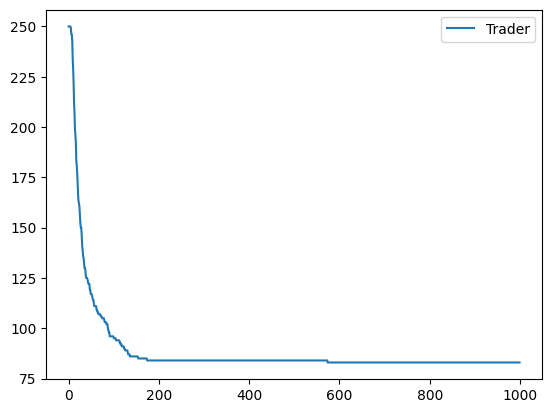

In [13]:
# Plot number of agent per time step 

results.plot(y= "Trader", use_index = True)

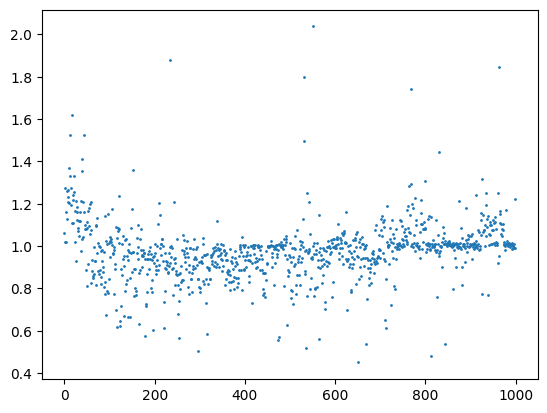

In [14]:
# plot trade price v/s setup 

y = list(results["Price"])
x = range(1000)

plt.scatter(x,y,s=1)

<BarContainer object of 999 artists>

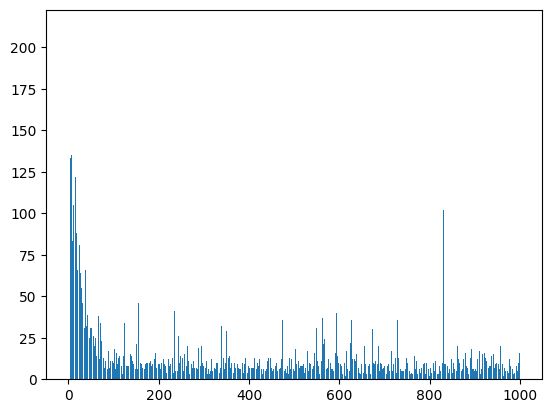

In [15]:
# plot trade volume 
plt.bar(results.index[1:], results["Trade Volume"][1:])

<BarContainer object of 990 artists>

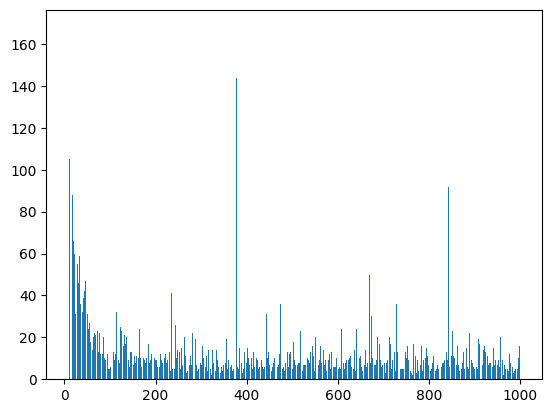

In [16]:
# plot trade volume 
plt.bar(results.index[10:], results["Trade Volume"][10:])

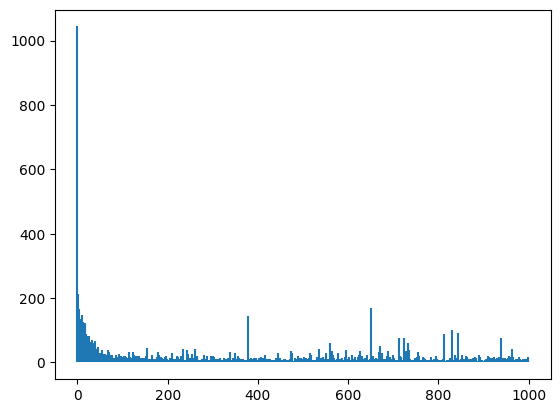

In [17]:
# Plot trade volume improved; 
for i in range(1000):
  plt.vlines(i,0,results["Trade Volume"][i])

In [19]:
# create a graph object; 
G = nx.Graph()

# add agent key to make intial node set
G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))

# Create edge list; 
for idx,row in agent_results.iterrows():
  if len(row["Trade Network"]) >0:
    for agent in row["Trade Network"]:
      G.add_edge(idx[1],agent)

      

In [23]:
nx.node_connectivity(G), nx.average_clustering(G),  nx.global_efficiency(G)

(0, 0.39892154679106234, 0.44328030246935796)

(array([97., 37., 22., 13.,  7., 11., 15., 20., 19.,  8.]),
 array([ 1. ,  8.6, 16.2, 23.8, 31.4, 39. , 46.6, 54.2, 61.8, 69.4, 77. ]),
 <BarContainer object of 10 artists>)

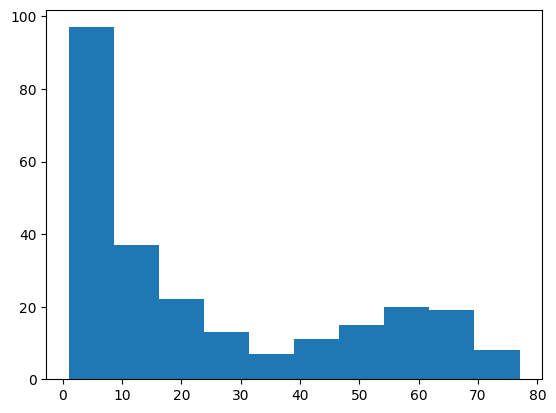

In [24]:
degree = [ d for n, d in G.degree()]
plt.hist(degree)

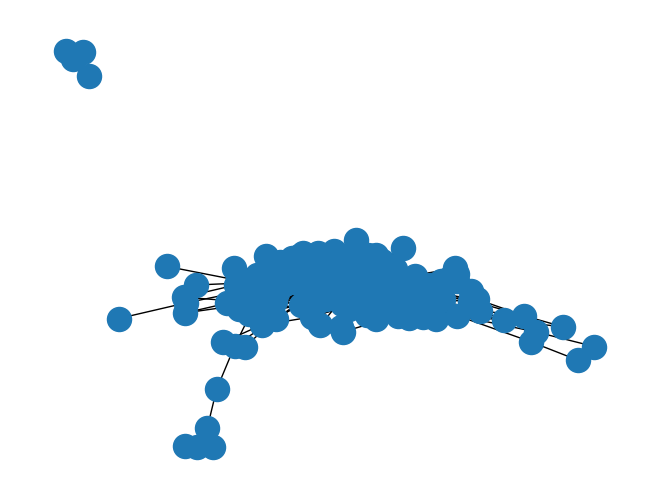

In [25]:
nx.draw(G)

# Batch Run and Analysis

In [29]:
params = { "width": 50, "height": 50,
           "vision_min": range(1,3),
           "metabolism_max": [3,5]}

results_batch = mesa.batch_run(
    SugarscapeG1mt,
    parameters = params,
    iterations =1,
    number_processes= 1,
    data_collection_period=1,
    display_progress= True
)

 25%|██▌       | 1/4 [01:48<05:26, 108.91s/it]<ipython-input-3-5205b0929a93>:24: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list).mean())
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4/4 [05:13<00:00, 78.33s/it]


In [30]:
import pandas as pd

results_df = pd.DataFrame(results_batch)
results_df

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price
0,0,0,0,50,50,1,3,250,818,0.942281
1,0,0,1,50,50,1,3,250,135,1.042238
2,0,0,2,50,50,1,3,250,87,1.077048
3,0,0,3,50,50,1,3,250,87,0.971088
4,0,0,4,50,50,1,3,250,91,0.869803
...,...,...,...,...,...,...,...,...,...,...
3999,3,0,996,50,50,2,5,86,9,1.084810
4000,3,0,997,50,50,2,5,86,4,1.125677
4001,3,0,998,50,50,2,5,86,11,1.279470
4002,3,0,999,50,50,2,5,86,3,1.203796


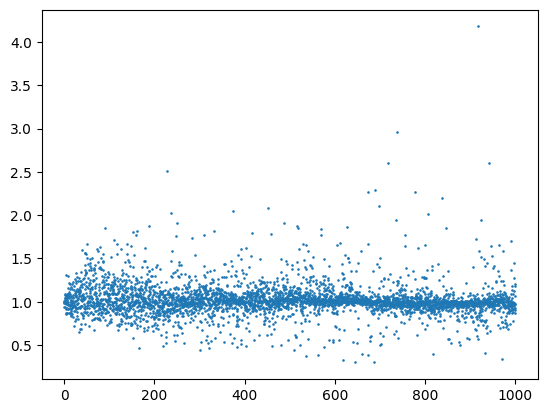

In [31]:
plt.scatter(results_df["Step"], results_df["Price"],s=0.75)

In [33]:
results_explore = results_df[results_df["metabolism_max"]==5]
results_explore

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price
1001,1,0,0,50,50,1,5,250,1101,1.007786
1002,1,0,1,50,50,1,5,250,150,1.083636
1003,1,0,2,50,50,1,5,250,170,0.979516
1004,1,0,3,50,50,1,5,250,126,1.032703
1005,1,0,4,50,50,1,5,250,109,0.914556
...,...,...,...,...,...,...,...,...,...,...
3999,3,0,996,50,50,2,5,86,9,1.084810
4000,3,0,997,50,50,2,5,86,4,1.125677
4001,3,0,998,50,50,2,5,86,11,1.279470
4002,3,0,999,50,50,2,5,86,3,1.203796


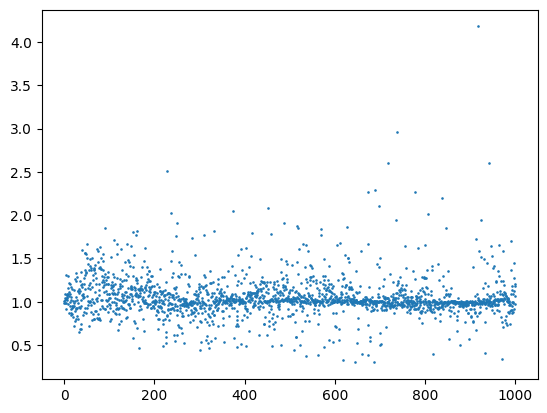

In [34]:
plt.scatter(results_explore["Step"], results_explore["Price"],s=0.75)

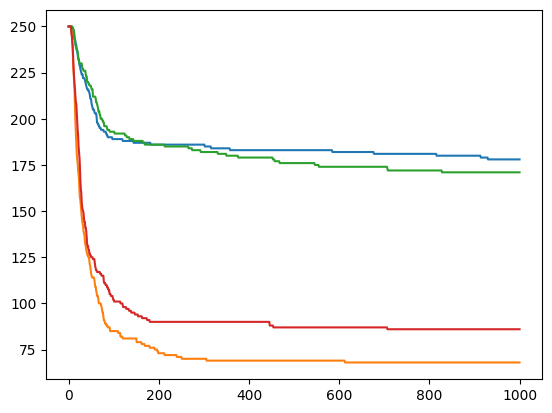

In [36]:
for i in range(4):
  result_explore = results_df[results_df["RunId"]==i]
  plt.plot(result_explore["Step"],result_explore["Trader"])